In [4]:
import decode_eeg
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pandas as pd
import scipy.stats as sista
import statsmodels.api as sm
from statsmodels.formula.api import ols
import pingouin

np.random.seed(42)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
output_dir = Path('./output')
fig_dir = output_dir / 'figures' / 'behavior'

behavior = None
experiment_names = ['1801','1901','1902']
for iexp,experiment_name in enumerate(experiment_names):
    
    data_dir = f'./data/{experiment_name}'
    exp = decode_eeg.Experiment(experiment_name,data_dir,test=False)
    
    for isub in range(exp.nsub):
        # Load subject's behavior data
        if behavior is None:
            behavior = pd.DataFrame(exp.load_behavior(isub))[['Subject','TrialType','ACC','SetSize','Timestamp']]
            behavior['Experiment'] = (np.ones(len(behavior))*iexp).astype(int)
        else:
            temp = pd.DataFrame(exp.load_behavior(isub))[['Subject','TrialType','ACC','SetSize','Timestamp']]
            temp['Experiment'] = (np.ones(len(temp))*iexp).astype(int)
            behavior = behavior.append(temp)

behavior.tail()

,Subject,TrialType,ACC,SetSize,Timestamp,Experiment
1074,20,1,1,1,1579734021,2
1075,20,1,1,1,1579734027,2
1076,20,1,1,4,1579734033,2
1077,20,1,1,3,1579734038,2
1078,20,1,1,1,1579734060,2


In [6]:
total_means = behavior.groupby(['Experiment','SetSize'])['ACC'].mean()
subject_means = behavior.groupby(['Experiment','SetSize','Subject'])['ACC'].mean().reset_index()
total_means

Experiment  SetSize
0           1          0.917015
            2          0.888095
            3          0.835514
            4          0.762686
1           1          0.966280
            2          0.917102
            3          0.832606
            4          0.756411
2           1          0.965916
            2          0.903212
            3          0.801378
            4          0.723733
Name: ACC, dtype: float64

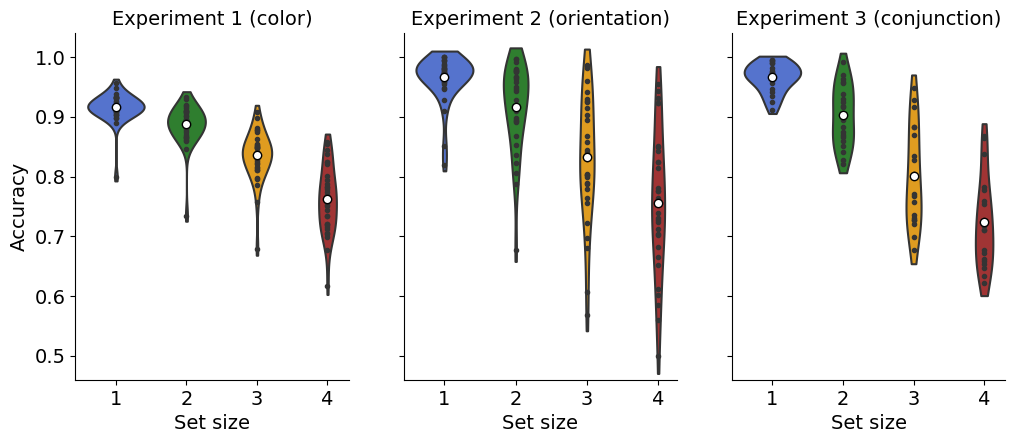

In [19]:
fig, axes = plt.subplots(1, 3, sharey=True, figsize=(12,4.5))
# fig.suptitle('Change detection accuracy',fontsize=18)
my_pal = {"royalblue", "firebrick", "forestgreen", "orange"}

# experiment 1
sns.violinplot(
    ax = axes[0], 
    x='SetSize',y='ACC', 
    data=subject_means[subject_means['Experiment']==0],
    dodge=True,inner='points',cut=.5,palette = my_pal)

axes[0].set_title('Experiment 1 (color)',fontsize=14)

# experiment 2
sns.violinplot(
    ax = axes[1], 
    x='SetSize',y='ACC', 
    data=subject_means[subject_means['Experiment']==1],
    dodge=True,inner='points',cut=.5,palette = my_pal) 

axes[1].set_title('Experiment 2 (orientation)',fontsize=14)

# experiment 3
sns.violinplot(
    ax = axes[2], 
    x='SetSize',y='ACC', 
    data=subject_means[subject_means['Experiment']==2],
    dodge=True,inner='points',cut=.5,palette = my_pal) 

axes[2].set_title('Experiment 3 (conjunction)',fontsize=14)

for iax,ax in enumerate(axes):

    # plot means
    ax.scatter(
        x = [0,1,2,3],
        y = [total_means[iax][1],total_means[iax][2],total_means[iax][3],total_means[iax][4]],
        c = 'white', edgecolors='k')

    # asethetics
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.setp(ax.get_xticklabels(), fontsize=14)
    plt.setp(ax.get_yticklabels(), fontsize=14)
    ax.set_xlabel('Set size',fontsize=14)
    if iax == 0:
        ax.set_ylabel('Accuracy',fontsize=14)
    else:
        ax.set_ylabel('')
plt.ylim([.46,1.04])
plt.savefig('output/figures/cd_accuracy.png',dpi=500,bbox_inches='tight')
plt.savefig('output/figures/cd_accuracy.pdf',dpi=500,bbox_inches='tight')
plt.show()

In [14]:
model_exp1 = ols('ACC ~ C(SetSize)', data=subject_means.loc[subject_means['Experiment']==0]).fit();
anova_table_exp1 = sm.stats.anova_lm(model_exp1, typ=1);
anova_table_exp1

,df,sum_sq,mean_sq,F,PR(>F)
C(SetSize),3.0,0.451782,0.150594,90.191793,2.015141e-31
Residual,128.0,0.213723,0.001670,NaN,NaN


In [15]:
model_exp2 = ols('ACC ~ C(SetSize)', data=subject_means.loc[subject_means['Experiment']==1]).fit();
anova_table_exp2 = sm.stats.anova_lm(model_exp2, typ=1);
anova_table_exp2

,df,sum_sq,mean_sq,F,PR(>F)
C(SetSize),3.0,0.788738,0.262913,32.927262,1.336688e-15
Residual,120.0,0.958158,0.007985,NaN,NaN


In [16]:
model_exp3 = ols('ACC ~ C(SetSize)', data=subject_means.loc[subject_means['Experiment']==2]).fit();
anova_table_exp3 = sm.stats.anova_lm(model_exp3, typ=1);
anova_table_exp3

,df,sum_sq,mean_sq,F,PR(>F)
C(SetSize),3.0,0.695943,0.231981,60.270951,4.766543e-20
Residual,76.0,0.292522,0.003849,NaN,NaN


# T-tests

In [17]:
print(subject_means.groupby('Experiment')['ACC'].mean())
print(subject_means.groupby('Experiment')['ACC'].std())
print(subject_means.groupby('Experiment')['Subject'].count()/4)

Experiment
0    0.849415
1    0.866869
2    0.848095
Name: ACC, dtype: float64
Experiment
0    0.071275
1    0.119174
2    0.111858
Name: ACC, dtype: float64
Experiment
0    33.0
1    31.0
2    20.0
Name: Subject, dtype: float64


In [11]:
pingouin.ttest(x=subject_means.loc[subject_means.Experiment==0,'ACC'],y=subject_means.loc[subject_means.Experiment==1,'ACC'])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-1.4109,198.504594,two-sided,0.159839,"[-0.04, 0.01]",0.179087,0.352,0.29724


In [13]:
pingouin.ttest(x=subject_means.loc[subject_means.Experiment==0,'ACC'],y=subject_means.loc[subject_means.Experiment==2,'ACC'])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.094589,118.341553,two-sided,0.924801,"[-0.03, 0.03]",0.014879,0.155,0.051253


In [14]:
pingouin.ttest(x=subject_means.loc[subject_means.Experiment==1,'ACC'],y=subject_means.loc[subject_means.Experiment==2,'ACC'])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,1.140545,176.334611,two-sided,0.255606,"[-0.01, 0.05]",0.16133,0.286,0.201407


# Timing

In [52]:
times = []
subs = []
exp = []
for iexp in [0,1,2]:
    df = behavior.loc[behavior.Experiment==iexp]
    for isub in np.unique(df['Subject']):
        df_sub = df.loc[df.Subject==isub]
        times.append((df_sub.iloc[-1]['Timestamp'] - df_sub.iloc[0]['Timestamp'])/60)
        subs.append(isub)
        exp.append(iexp)

In [35]:
print(np.mean(times))
print(min(times))
print(max(times))

104.89176706827308
73.05
132.45


# K


In [25]:
# Functions for calculating K from behavior
def calc_outcome(row):
    """
    calculate outcome of trial 
        hit: notice a change
        miss: fail to notice a change
        rej: notice there is no change
        fa (false alarm): notice change when there isn't one
    """
    accuracy = row['ACC']
    change = row['TrialType']
    if change == 1:
        if accuracy == 1:
            trial_outcome = 'hit'
        else:
            trial_outcome = 'miss'

    if change == 0:
        if accuracy == 1:
            trial_outcome = 'rej'
        else: 
            trial_outcome = 'fa'
    return trial_outcome

def _calc_k(outcome, change, ss):
    """
    a simple function that returns K.
    """
    
    hits = sum(outcome == 'hit')
    fa = sum(outcome == 'fa')

    num_change = sum(change==1)
    num_no_change = sum(change==0)

    h = hits/num_change
    f = fa/num_no_change
    k = ss*(h-f)
    return k

def calc_k(beh,ss):
    """
    Runs previous functions and returns subject K.
    """
    beh = beh[beh['SetSize']==ss]
    beh['outcome']=beh.apply(lambda row : calc_outcome(row), axis = 1)
    k = _calc_k(beh['outcome'],beh['TrialType'],ss)
    return k

In [26]:
%%capture
experiment_names = ['1801','1901','1902']
k = []
exps = []
ss = []
for iexp,experiment_name in enumerate(experiment_names):
    
    data_dir = f'./data/{experiment_name}'
    exp = decode_eeg.Experiment(experiment_name,data_dir,test=False)
    
    for isub in range(exp.nsub):
        # Load subject's behavior data
        behavior = pd.DataFrame(exp.load_behavior(isub))
        k.append(calc_k(behavior,1))
        k.append(calc_k(behavior,2))
        k.append(calc_k(behavior,3))
        k.append(calc_k(behavior,4))
    exps.append(np.repeat(iexp,exp.nsub*4))
    ss.append(np.tile([1,2,3,4],exp.nsub))

In [27]:
# df = pd.DataFrame({'exp':np.concatenate(exps),'k':k,'ss':np.concatenate(ss)})
df = pd.DataFrame({'Experiment':np.concatenate(exps), 'Set size': np.concatenate(ss), 'K': k})

In [28]:
total_means = df.groupby(['Experiment','Set size'])['K'].mean()
total_means

Experiment  Set size
0           1           0.828734
            2           1.549287
            3           2.008723
            4           2.096505
1           1           0.929879
            2           1.658631
            3           1.985427
            4           2.055157
2           1           0.930983
            2           1.610887
            3           1.806604
            4           1.766841
Name: K, dtype: float64

In [36]:
sing = df.loc[(df['Experiment']==0)|(df['Experiment']==1)]
conj = df.loc[df['Experiment']==2]

In [37]:
sing

,Experiment,Set size,K
0,0,1,0.816658
1,0,2,1.399474
2,0,3,1.863962
3,0,4,1.721865
4,0,1,0.824092
...,...,...,...
251,1,4,2.579313
252,1,1,0.929754
253,1,2,1.560700
254,1,3,1.818343


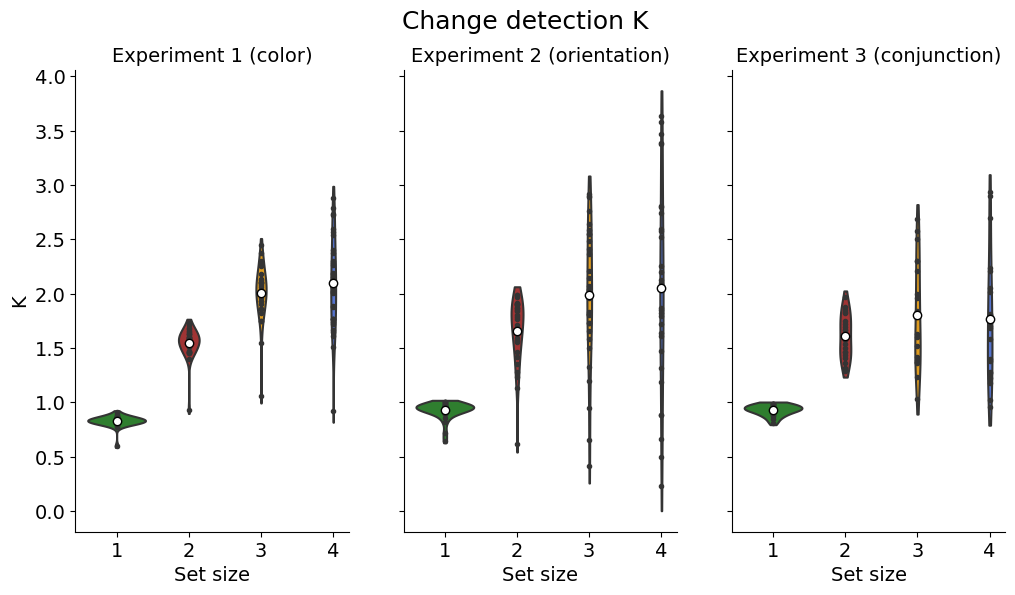

In [9]:
fig, axes = plt.subplots(1, 3, sharey=True, figsize=(12,6))
fig.suptitle('Change detection K',fontsize=18)
my_pal = {"royalblue", "firebrick", "forestgreen", "orange"}

# experiment 1
sns.violinplot(
    ax = axes[0], 
    x='Set size',y='K', 
    data=df[df['Experiment']==0],
    dodge=True,inner='points',cut=.5,palette = my_pal)

axes[0].set_title('Experiment 1 (color)',fontsize=14)

# experiment 2
sns.violinplot(
    ax = axes[1], 
    x='Set size',y='K', 
    data=df[df['Experiment']==1],
    dodge=True,inner='points',cut=.5,palette = my_pal) 

axes[1].set_title('Experiment 2 (orientation)',fontsize=14)

# experiment 3
sns.violinplot(
    ax = axes[2], 
    x='Set size',y='K', 
    data=df[df['Experiment']==2],
    dodge=True,inner='points',cut=.5,palette = my_pal) 

axes[2].set_title('Experiment 3 (conjunction)',fontsize=14)

for iax,ax in enumerate(axes):

    # plot means
    ax.scatter(
        x = [0,1,2,3],
        y = [total_means[iax][1],total_means[iax][2],total_means[iax][3],total_means[iax][4]],
        c = 'white', edgecolors='k')

    # asethetics
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.setp(ax.get_xticklabels(), fontsize=14)
    plt.setp(ax.get_yticklabels(), fontsize=14)
    ax.set_xlabel('Set size',fontsize=14)
    if iax == 0:
        ax.set_ylabel('K',fontsize=14)
    else:
        ax.set_ylabel('')
# plt.ylim([.46,1.04])
# plt.savefig('output/figures/cd_accuracy.png',dpi=500)
# plt.savefig('output/figures/cd_accuracy.pdf',dpi=500)
plt.show()

# Single feature versus conjuncion, within-subject

In [15]:
# Experiment setup
experiment_name1 = '1801'
experiment_name2 = '1901'
experiment_name3 = '1902'
data_dir1 = f'./data/{experiment_name1}'
data_dir2 = f'./data/{experiment_name2}'
data_dir3 = f'./data/{experiment_name3}'

exp1 = decode_eeg.Experiment(experiment_name1,data_dir1)
exp2 = decode_eeg.Experiment(experiment_name2,data_dir2)
exp3 = decode_eeg.Experiment(experiment_name3,data_dir3)

In [16]:
# Classification parameters and setup
time_window = 50
time_step = 25
trial_average = 20
n_splits = 1000
group_dict = {0:[1],1:[2],2:[3],3:[4]}
wrangl = decode_eeg.Wrangler(exp1.info['times'],time_window,time_step,trial_average,n_splits,group_dict)

sync = decode_eeg.Experiment_Syncer(experiments=[exp1,exp2,exp3],
                                    wrangler = wrangl,
                                    train_group = [experiment_name1,experiment_name2])

clfr = decode_eeg.Classification(wrangl,sync.nsub)

In [17]:
ss4_acc = np.empty((len(sync.matched_ids),3))
for isub,sub in enumerate(sync.matched_ids):
    beh = sync.load_behavior(sub)
    for iexp,exp in enumerate(['1801','1901','1902']):
        exp_beh = pd.DataFrame(beh[exp])
        ss4_acc[isub,iexp] = exp_beh.groupby('SetSize')['ACC'].mean().loc[4]

In [18]:
acc = pd.DataFrame(ss4_acc,columns=['Color','Orientation','Conjunction'])
acc['Single Feature'] = acc.loc[:,['Color','Orientation']].mean(1)
acc.head()

,Color,Orientation,Conjunction,Single Feature
0,0.824121,0.923913,0.837209,0.874017
1,0.715847,0.723514,0.717884,0.719681
2,0.857500,0.954674,0.864198,0.906087
3,0.734483,0.652174,0.709877,0.693328
4,0.788204,0.731343,0.727273,0.759774


In [23]:
print(f"Mean accuracy\n{acc.loc[:,['Single Feature', 'Conjunction']].mean()}")
print(f"Mean SEM\n{acc.loc[:,['Single Feature', 'Conjunction']].sem()}")
pingouin.ttest(x=acc['Single Feature'],y=acc['Conjunction'],alternative='greater',paired=True)

Mean accuracy
Single Feature    0.764374
Conjunction       0.722885
dtype: float64
Mean SEM
Single Feature    0.016941
Conjunction       0.016594
dtype: float64


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,3.809217,19,greater,0.000592,"[0.02, inf]",0.553244,63.129,0.770266


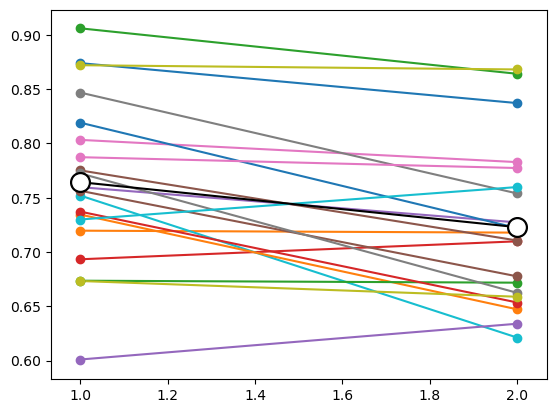

In [21]:
for i in range(20):
    plt.plot([1,2],acc.loc[i,['Single Feature', 'Conjunction']],zorder=-100)
    plt.scatter([1,2],acc.loc[i,['Single Feature', 'Conjunction']])
plt.plot([1,2],acc.loc[:,['Single Feature', 'Conjunction']].mean(0),c='k',zorder=-100)
plt.scatter([1,2],acc.loc[:,['Single Feature', 'Conjunction']].mean(0),s=200,c='k',marker='o')
plt.scatter([1,2],acc.loc[:,['Single Feature', 'Conjunction']].mean(0),s=120,c='w',marker='o')

plt.show()